## Submission Image Classification series

### Nama: Albert Budi Christian
### Email: albert.christian92@gmail.com

In [1]:
# Import library yang dibutuhkan 

import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


from sklearn.metrics import classification_report,accuracy_score

## Dataset

Download from kaggle link : https://www.kaggle.com/chetankv/dogs-cats-images

In [2]:
# Set lokasi folder dataset
train_dir_ = Path('../input/dogs-cats-images/dataset/training_set')
test_dir_ = Path('../input/dogs-cats-images/dataset/test_set')

#membuat list berdasarkan file path untuk training dan testing
train_filepaths = list(train_dir_.glob(r'**/*.jpg'))
test_filepaths = list(test_dir_.glob(r'**/*.jpg'))

# Mapping label dan menggabungkan dengan path
labels_training = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_filepaths))
labels_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

train_filepaths = pd.Series(train_filepaths, name = 'Gambar').astype(str)
test_filepaths = pd.Series(test_filepaths, name = 'Gambar').astype(str)

train_labels = pd.Series(labels_training, name='Label')
test_labels = pd.Series(labels_test, name='Label')

df_train = pd.concat([train_filepaths, train_labels], axis=1)
df_test = pd.concat([test_filepaths, test_labels], axis=1)

In [3]:
#membuat data loading + implement data augmentation, di sini saya set validation 0.3 dari train
train_generator = ImageDataGenerator(
        rescale = 1./255,
        shear_range = 0.2,
        zoom_range = 0.1,
        rotation_range = 20,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        vertical_flip = True,
    )
test_generator = ImageDataGenerator(
        rescale = 1./255
    )
batch_size =32

In [4]:
#loading data train, validation, dan test
train_gambar = train_generator.flow_from_dataframe( 
    dataframe = df_train,
    x_col = "Gambar",
    y_col = "Label",
    target_size = (128, 128),
    shuffle=True,
    seed = 2,
    batch_size = batch_size,
    color_mode='rgb',
    class_mode='categorical',
    fill_mode='nearest',
    subset='training'
)

test_gambar = test_generator.flow_from_dataframe( 
    dataframe = df_test,
    x_col = "Gambar",
    y_col = "Label",
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


In [5]:
# Di sini saya implementasi model Mobile Net
mobilenet = MobileNet(input_shape = (128, 128, 3), include_top = False, weights = 'imagenet')
for layer in mobilenet.layers:
    layer.trainable = False

17227776/17225924 [==============================] - 1s 0us/step


In [6]:
mobilenet_model = Sequential()
mobilenet_model.add(BatchNormalization(input_shape = (128, 128, 3)))
mobilenet_model.add(mobilenet)
mobilenet_model.add(BatchNormalization())
mobilenet_model.add(GlobalAveragePooling2D())
mobilenet_model.add(Dropout(0.5))
mobilenet_model.add(Dense(2, activation = 'softmax'))

mobilenet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 128, 128, 3)       12        
_________________________________________________________________
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 1024)        4096      
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,235,022
Trainable params: 4,104
Non-trainable params: 3,230,918
__________________________________________

In [7]:
# Atur Callbacks
ini_callback = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 25, restore_best_weights = True)]

# Compile mobile net dan set optimizer, di sini saya menggunakan adam
mobilenet_model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics=['accuracy'])

# Training dan validasi
mobilenet_history = mobilenet_model.fit(train_gambar, epochs = 50, validation_data = test_gambar, callbacks = ini_callback)

Epoch 1/50
250/250 [==============================] - 108s 416ms/step - loss: 0.5017 - accuracy: 0.7695 - val_loss: 0.1155 - val_accuracy: 0.9590
Epoch 2/50
250/250 [==============================] - 57s 227ms/step - loss: 0.2798 - accuracy: 0.8859 - val_loss: 0.1020 - val_accuracy: 0.9620
Epoch 3/50
250/250 [==============================] - 57s 228ms/step - loss: 0.2423 - accuracy: 0.9031 - val_loss: 0.0930 - val_accuracy: 0.9655
Epoch 4/50
250/250 [==============================] - 57s 227ms/step - loss: 0.2376 - accuracy: 0.9040 - val_loss: 0.0870 - val_accuracy: 0.9665
Epoch 5/50
250/250 [==============================] - 57s 227ms/step - loss: 0.2226 - accuracy: 0.9068 - val_loss: 0.0901 - val_accuracy: 0.9665
Epoch 6/50
250/250 [==============================] - 57s 228ms/step - loss: 0.2308 - accuracy: 0.9084 - val_loss: 0.0861 - val_accuracy: 0.9685
Epoch 7/50
250/250 [==============================] - 57s 229ms/step - loss: 0.2270 - accuracy: 0.9061 - val_loss: 0.0887 - val_a

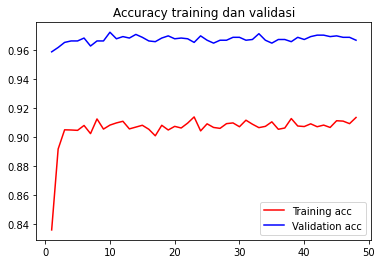

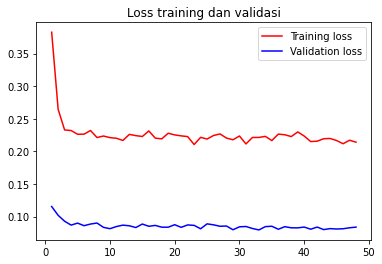

In [8]:
# Plot akurasi

acc = mobilenet_history.history['accuracy']
val_acc = mobilenet_history.history['val_accuracy']
loss = mobilenet_history.history['loss']
val_loss = mobilenet_history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Accuracy training dan validasi')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Loss training dan validasi')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

In [9]:
score_mn = mobilenet_model.evaluate(test_gambar)
print("Test Loss:", score_mn[0])
print("Test Accuracy:", score_mn[1])

63/63 [==============================] - 6s 94ms/step - loss: 0.0866 - accuracy: 0.9655
Test Loss: 0.08660251647233963
Test Accuracy: 0.965499997138977


**Save model to TF Lite**

In [10]:
# Convert model untuk deployment
converter = tf.lite.TFLiteConverter.from_keras_model(mobilenet_model)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('animal.tflite', 'wb') as f:
  f.write(tflite_model)